Extraindo fluxos...
Concluído.


/tmp/ipykernel_13437/4161944249.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 4)


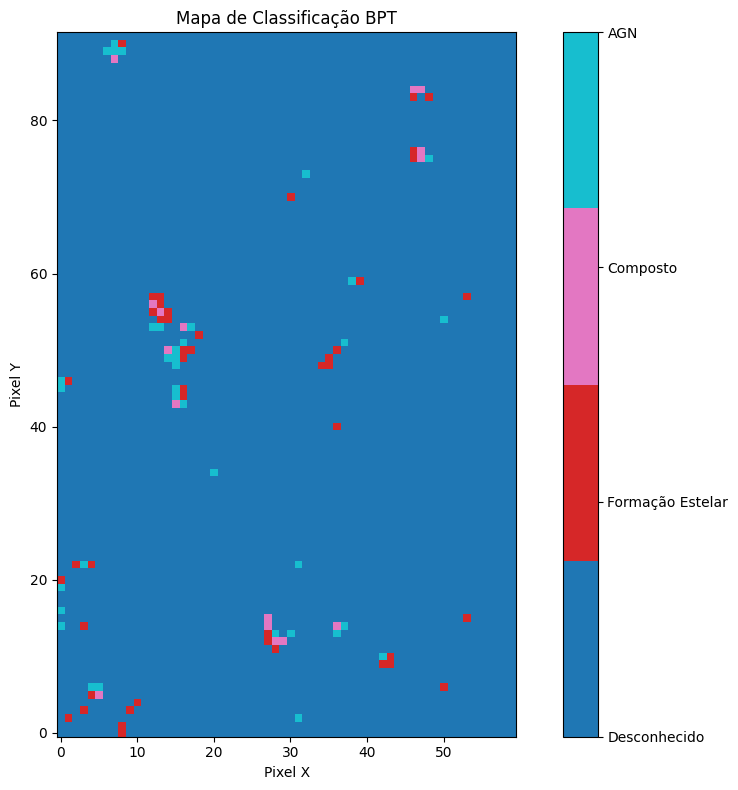

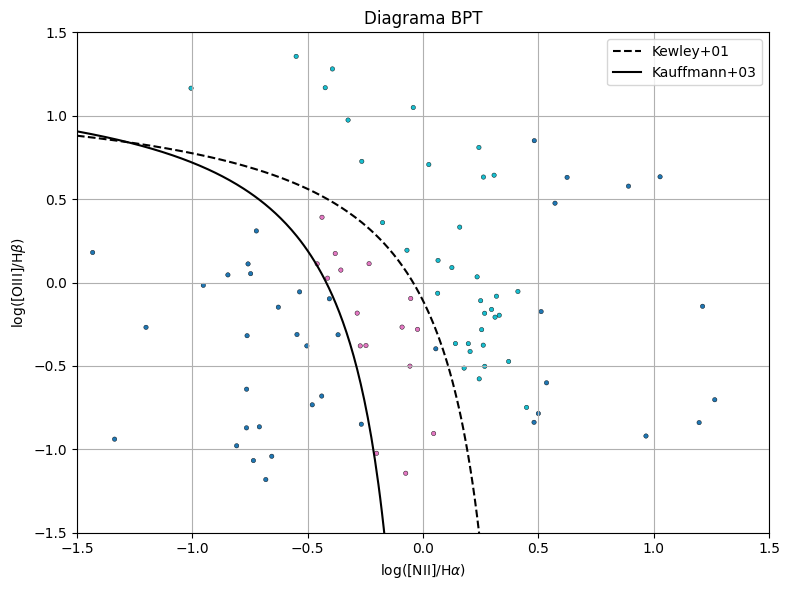

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit

# --- Função de Gaussiana ---
def gauss(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma)**2)

# --- Função para extração de fluxo com subtração de contínuo (e opcional ajuste Gaussiano) ---
def fluxo_linha(spectrum, wavelengths, lambda0, delta=5, delta_cont=10, usar_gauss=False):
    idx0 = np.searchsorted(wavelengths, lambda0)
    idx_min = max(idx0 - delta, 0)
    idx_max = min(idx0 + delta, len(wavelengths) - 1)
    janela_linha = spectrum[idx_min:idx_max+1]
    janela_lambda = wavelengths[idx_min:idx_max+1]

    idx_cont1 = max(idx_min - delta_cont, 0)
    idx_cont2 = min(idx_max + delta_cont, len(spectrum))
    cont1 = spectrum[idx_cont1:idx_min]
    cont2 = spectrum[idx_max+1:idx_cont2]
    continuum = np.median(np.concatenate([cont1, cont2]))

    janela_corrigida = janela_linha - continuum

    if usar_gauss:
        try:
            p0 = [janela_corrigida.max(), lambda0, 1.0]
            popt, _ = curve_fit(gauss, janela_lambda, janela_corrigida, p0=p0)
            fluxo = popt[0] * popt[2] * np.sqrt(2 * np.pi)
        except:
            fluxo = np.sum(janela_corrigida)  # fallback se ajuste falhar
    else:
        fluxo = np.sum(janela_corrigida)

    return max(fluxo, 0)

# --- Parâmetros ---
delta = 5
delta_cont = 10
flux_min = 1e-15
usar_gauss = False  

linhas_bpt = {
    "Ha": 6562.8,
    "Hb": 4861.3,
    "NII": 6583.4,
    "OIII": 5007.0
}

# --- Abrir cubo FITS ---
hdul = fits.open('../NGC_CUBE/ggrNGC1399.fits')
data = hdul[0].data
header = hdul[0].header
hdul.close()

n_waves, ny, nx = data.shape
crval3 = header['CRVAL3']
cdelt3 = header['CDELT3']
crpix3 = header['CRPIX3']
wavelengths = crval3 + (np.arange(n_waves) + 1 - crpix3) * cdelt3

# --- Inicializar fluxos ---
flux_maps = {name: np.zeros((ny, nx)) for name in linhas_bpt}

print("Extraindo fluxos...")
for iy in range(ny):
    for ix in range(nx):
        spectrum = data[:, iy, ix]
        for name, lambda0 in linhas_bpt.items():
            flux_maps[name][iy, ix] = fluxo_linha(spectrum, wavelengths, lambda0,
                                                  delta, delta_cont, usar_gauss)
print("Concluído.")

# --- Calcular razões logarítmicas ---
mask_valido = np.logical_and.reduce([
    flux_maps["Ha"] > flux_min,
    flux_maps["Hb"] > flux_min,
    flux_maps["NII"] > flux_min,
    flux_maps["OIII"] > flux_min
])

n2_ha = np.full_like(flux_maps["Ha"], np.nan)
o3_hb = np.full_like(flux_maps["Ha"], np.nan)

n2_ha[mask_valido] = np.log10(flux_maps["NII"][mask_valido] / flux_maps["Ha"][mask_valido])
o3_hb[mask_valido] = np.log10(flux_maps["OIII"][mask_valido] / flux_maps["Hb"][mask_valido])

# --- Função de classificação BPT ---
def classify_pixel(n2_ha_val, o3_hb_val):
    if np.isnan(n2_ha_val) or np.isnan(o3_hb_val):
        return 0  # Desconhecido
    if o3_hb_val > 0.61 / (n2_ha_val - 0.47) + 1.19:
        return 3  # AGN
    elif o3_hb_val > 0.61 / (n2_ha_val - 0.05) + 1.3:
        return 2  # Composto
    else:
        return 1  # Formação Estelar

classification_map = np.zeros_like(n2_ha, dtype=int)
for iy in range(ny):
    for ix in range(nx):
        classification_map[iy, ix] = classify_pixel(n2_ha[iy, ix], o3_hb[iy, ix])

# --- Plot do mapa BPT ---
plt.figure(figsize=(10, 8))
cmap = plt.cm.get_cmap('tab10', 4)
im = plt.imshow(classification_map, origin='lower', cmap=cmap, vmin=0, vmax=3)
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(['Desconhecido', 'Formação Estelar', 'Composto', 'AGN'])
plt.title('Mapa de Classificação BPT')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.tight_layout()
plt.savefig('mapa_bpt_classificacao.png', dpi=300)
plt.show()

# --- Plot do diagrama BPT (corrigido!) ---
plt.figure(figsize=(8, 6))
sc = plt.scatter(n2_ha[mask_valido], o3_hb[mask_valido], 
                 c=classification_map[mask_valido], cmap=cmap, s=10, edgecolor='k', linewidth=0.3)

# Curvas sem explodir (domínio limitado!)
x_kewley = np.linspace(-1.5, 0.45, 200)
kewley_curve = 0.61 / (x_kewley - 0.47) + 1.19
x_kauff = np.linspace(-1.5, 0.03, 200)
kauffmann_curve = 0.61 / (x_kauff - 0.05) + 1.3

plt.plot(x_kewley, kewley_curve, 'k--', label='Kewley+01')
plt.plot(x_kauff, kauffmann_curve, 'k-', label='Kauffmann+03')

plt.xlabel(r'log([NII]/H$\alpha$)')
plt.ylabel(r'log([OIII]/H$\beta$)')
plt.title('Diagrama BPT')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('diagrama_bpt.png', dpi=300)
plt.show()



In [3]:
from astropy.io import fits

hdu = fits.PrimaryHDU(classification_map)
hdu.writeto('bpt_classification_map.fits', overwrite=True)
print("Mapa de classificação BPT salvo como 'bpt_classification_map.fits'.")


Mapa de classificação BPT salvo como 'bpt_classification_map.fits'.


In [4]:
unique, counts = np.unique(classification_map, return_counts=True)
total = np.sum(counts)

print("Fração de cada classe no cubo:")
for cls, count in zip(unique, counts):
    frac = count / total * 100
    if cls == 0:
        nome = 'Desconhecido'
    elif cls == 1:
        nome = 'Formação Estelar'
    elif cls == 2:
        nome = 'Composto'
    elif cls == 3:
        nome = 'AGN'
    print(f"{nome}: {count} pixels ({frac:.2f}%)")


Fração de cada classe no cubo:
Desconhecido: 5422 pixels (98.22%)
Formação Estelar: 46 pixels (0.83%)
Composto: 16 pixels (0.29%)
AGN: 36 pixels (0.65%)


In [5]:
# --- Cálculo da fração de cada classe no mapa de classificação BPT ---
unique, counts = np.unique(classification_map, return_counts=True)
total_pixels = np.sum(counts)

print("\nResumo da Classificação BPT no Cubo Espectral:")
print(f"Total de pixels válidos: {total_pixels}\n")
for cls, count in zip(unique, counts):
    frac = (count / total_pixels) * 100
    if cls == 0:
        nome = 'Desconhecido'
    elif cls == 1:
        nome = 'Formação Estelar'
    elif cls == 2:
        nome = 'Composto'
    elif cls == 3:
        nome = 'AGN'
    print(f"Classe: {nome:<18} | Pixels: {count:<5} | Fração: {frac:.2f}%")



Resumo da Classificação BPT no Cubo Espectral:
Total de pixels válidos: 5520

Classe: Desconhecido       | Pixels: 5422  | Fração: 98.22%
Classe: Formação Estelar   | Pixels: 46    | Fração: 0.83%
Classe: Composto           | Pixels: 16    | Fração: 0.29%
Classe: AGN                | Pixels: 36    | Fração: 0.65%


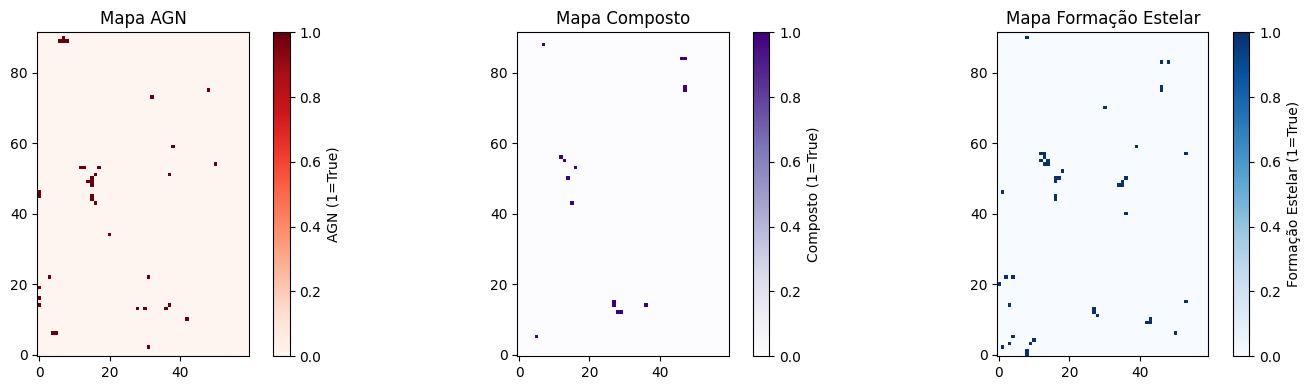

In [6]:
# --- Geração de mapas binários para cada classe ---
mapa_agn = (classification_map == 3).astype(int)       # AGN = 3
mapa_composto = (classification_map == 2).astype(int)  # Composto = 2
mapa_formacao = (classification_map == 1).astype(int)  # Formação Estelar = 1

# --- Plot de cada mapa individual ---
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(mapa_agn, origin='lower', cmap='Reds')
plt.title('Mapa AGN')
plt.colorbar(label='AGN (1=True)')

plt.subplot(1, 3, 2)
plt.imshow(mapa_composto, origin='lower', cmap='Purples')
plt.title('Mapa Composto')
plt.colorbar(label='Composto (1=True)')

plt.subplot(1, 3, 3)
plt.imshow(mapa_formacao, origin='lower', cmap='Blues')
plt.title('Mapa Formação Estelar')
plt.colorbar(label='Formação Estelar (1=True)')

plt.tight_layout()
plt.show()
